In [1]:
%pylab inline
import numpy as np
from scipy.integrate import odeint
import itertools
from Oracle_Training import *
import json
from SparseARD import*
np.random.seed(0)

retrain = False

noise_percent = 0.1
n_trials = 10
n_sample = 2500

tol = 1e-8 # tolerance for ARD algorithm
verbose = True

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Translated into Python from AK Kassam and LN Trefethen, July 2002
from scipy.fftpack import fft, ifft, fftfreq

# Spatial grid and IC
n = 512
m = 1024
x = 32*np.pi*np.linspace(0,1,n+1)[:-1]
u = np.cos(x/8)*(1+np.sin(x/16))
v = fft(u)

# Precompute various ETDRK4 scalar quantities:
h = 0.01
k = np.array(np.concatenate([np.arange(n/2),np.array([0]),-np.arange(1,n/2)[::-1]]))/16
L = (k**2-k**4)
E = np.exp(h*L)
E2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(M)+0.5)/M)
LR = h*np.vstack([L for _ in range(M)]) + np.hstack([np.reshape(r, (M,1)) for _ in range(n)])
LR = LR.T
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis = 1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis = 1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis = 1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis = 1))

uu = [u]; tt= [0]
tmax = 150; jmax = int(tmax/h); jplt=floor(tmax/m/h)
g = -0.5*1j*k

for j in range(1,jmax+1):
    
    t = j*h
    Nv = g*fft(np.real(ifft(v))**2)
    a = E2*v+Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = E2*v+Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = E2*a+Q*(2*Nb-Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = E*v+Nv*f1+2*(Na+Nb)*f2+Nc*f3
    
    if j%jplt == 0:
        
        u = np.real(ifft(v))
        uu.append(u)
        tt.append(t)
        
u = np.stack(uu).T; t = np.array(tt); dx = x[1]-x[0]; dt = t[1]-t[0]
n,m = u.shape

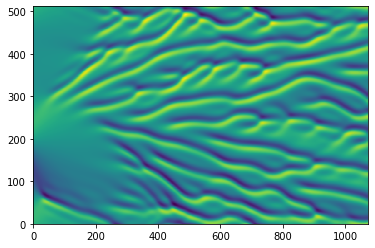

In [3]:
pcolor(u)

In [4]:
un = u + 0.01*noise_percent*np.std(u)*np.random.randn(*u.shape)

In [5]:
y, Theta, rhs_des = build_linear_system(un, dt, dx, D=4, P=4)

In [6]:
xi_true = np.zeros((Theta.shape[1],1))

xi_true[[i for i, s in enumerate(rhs_des) if 'uu_{x}' == s]] = 1
xi_true[[i for i, s in enumerate(rhs_des) if 'u_{xx}' == s]] = 1
xi_true[[i for i, s in enumerate(rhs_des) if 'u_{xxxx}' == s]] = 1

xi = xi_true

In [7]:
if retrain:
    
    L1_err = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    L2_err = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    Added = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    Missed = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    Xi = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    
    for trial in range(n_trials):
    
        print('Trial', trial+1, 'of', str(n_trials)+'.')

        sample = np.random.choice(n*m, n_sample, replace = False)
        Theta_sample = Theta[sample, :]
        y_sample = y[sample,:]

        # Test each method
        print('Training ARD.')
        gamma_ARD,sigma2_ARD,mu_xi_ARD,_ = SBL([Theta_sample,y_sample], \
                                           sigma2=1, \
                                           estimate_sigma=True, \
                                           maxit=500, \
                                           verbose=False, \
                                           tol=tol)
        ARD_results = gamma_ARD,sigma2_ARD,mu_xi_ARD

        print('Training ARDr.')
        lams = [np.linalg.norm(y)**2*l for l in [0,1e-1,1e0,1e1,1e2,1e3,1e4]]
        gamma_ARDr, sigma2_ARDr, mu_xi_ARDr = Train_ARDr(Theta_sample,y_sample,xi_true,\
                                                         ARD_results=ARD_results,\
                                                         lams = lams,\
                                                         verbose=verbose)

        print('Training ARDvi.')
        alphas = [1,2,4,8,16,32,64,128,256]
        gamma_ARDvi, sigma2_ARDvi, mu_xi_ARDvi = Train_ARDvi(Theta_sample,y_sample,xi_true,\
                                                             ARD_results=ARD_results, \
                                                             alphas=alphas,\
                                                             verbose=verbose)

        print('Training STSBL.')
        taus = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1]
        gamma_STSBL, sigma2_STSBL, mu_xi_STSBL = Train_M_STSBL(Theta_sample,y_sample,xi_true,\
                                                               ARD_results=ARD_results,\
                                                               taus=taus,\
                                                               verbose=verbose)

        print('Training lSTSBL.')
        taus = [np.inf,1e-8,1e-6,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
        gamma_lSTSBL, sigma2_lSTSBL, mu_xi_lSTSBL = Train_L_STSBL(Theta_sample,y_sample,xi_true,\
                                                                  ARD_results=ARD_results, \
                                                                  taus=taus,\
                                                                  verbose=verbose)

        print('Training dSTSBL.')
        taus = [0,1e-2,1e-1,1,1e1,1e2,1e3]
        gamma_dSTSBL, sigma2_dSTSBL, mu_xi_dSTSBL = Train_MAP_STSBL(Theta_sample,y_sample,xi_true,\
                                                                  ARD_results=ARD_results,\
                                                                  taus=taus,\
                                                                  verbose=verbose)

        # Record predictions
        Xi['ARD'].append(list(mu_xi_ARD.flatten()))
        Xi['ARDr'].append(list(mu_xi_ARDr.flatten()))
        Xi['ARDvi'].append(list(mu_xi_ARDvi.flatten()))
        Xi['mSTSBL'].append(list(mu_xi_STSBL.flatten()))
        Xi['lSTSBL'].append(list(mu_xi_lSTSBL.flatten()))
        Xi['dSTSBL'].append(list(mu_xi_dSTSBL.flatten()))

        # Record errors
        L1_err['ARD'].append(np.linalg.norm(xi - mu_xi_ARD, 1))
        L1_err['ARDr'].append(np.linalg.norm(xi - mu_xi_ARDr, 1))
        L1_err['ARDvi'].append(np.linalg.norm(xi - mu_xi_ARDvi, 1))
        L1_err['mSTSBL'].append(np.linalg.norm(xi - mu_xi_STSBL, 1))
        L1_err['lSTSBL'].append(np.linalg.norm(xi - mu_xi_lSTSBL, 1))
        L1_err['dSTSBL'].append(np.linalg.norm(xi - mu_xi_dSTSBL, 1))

        L2_err['ARD'].append(np.linalg.norm(xi - mu_xi_ARD, 2))
        L2_err['ARDr'].append(np.linalg.norm(xi - mu_xi_ARDr, 2))
        L2_err['ARDvi'].append(np.linalg.norm(xi - mu_xi_ARDvi, 2))
        L2_err['mSTSBL'].append(np.linalg.norm(xi - mu_xi_STSBL, 2))
        L2_err['lSTSBL'].append(np.linalg.norm(xi - mu_xi_lSTSBL, 2))
        L2_err['dSTSBL'].append(np.linalg.norm(xi - mu_xi_dSTSBL, 2))

        _,added,missed = sparsity_err(mu_xi_ARD,xi)
        Added['ARD'].append(added)
        Missed['ARD'].append(missed)

        _,added,missed = sparsity_err(mu_xi_ARDr,xi)
        Added['ARDr'].append(added)
        Missed['ARDr'].append(missed)

        _,added,missed = sparsity_err(mu_xi_ARDvi,xi)
        Added['ARDvi'].append(added)
        Missed['ARDvi'].append(missed)

        _,added,missed = sparsity_err(mu_xi_STSBL,xi)
        Added['mSTSBL'].append(added)
        Missed['mSTSBL'].append(missed)

        _,added,missed = sparsity_err(mu_xi_lSTSBL,xi)
        Added['lSTSBL'].append(added)
        Missed['lSTSBL'].append(missed)

        _,added,missed = sparsity_err(mu_xi_dSTSBL,xi)
        Added['dSTSBL'].append(added)
        Missed['dSTSBL'].append(missed)

In [8]:
if retrain:
    with open('./saved_results/KS_results.json','w') as f:
        json.dump({'L2_err': L2_err, \
                   'L1_err': L1_err, \
                   'Added' : Added, \
                   'Missed' : Missed, \
                   'Xi': Xi}, f)
else:
    with open('./saved_results/KS_results.json','r') as f:
        results = json.load(f)
    L2_err = results['L2_err']    
    L1_err = results['L1_err']    
    Added = results['Added']
    Missed = results['Missed']
    Xi = results['Xi']

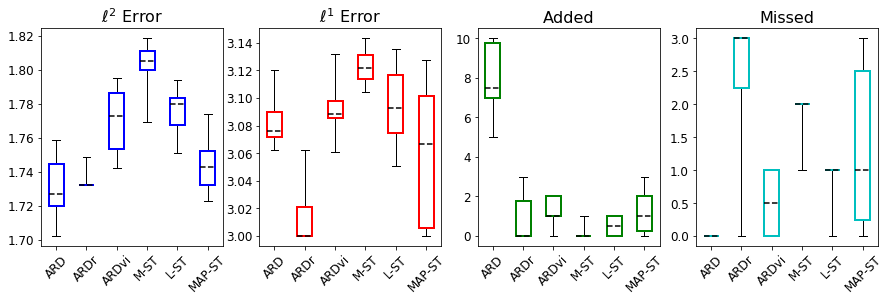

In [9]:
figure(figsize = (15,4))

lw = 2
label_fs = 16

whis = [0,100]
showfliers = False

subplot(1,4,1)
title(r'$\ell^2$ Error', fontsize = 16)
bp1 = boxplot([L2_err[key] for key in L2_err.keys()], positions = np.arange(6), \
              patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker,cap in zip(bp1['boxes'], bp1['whiskers'], bp1['caps']):
    box.set(color='blue', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp1['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,2)
title(r'$\ell^1$ Error', fontsize = 16)
bp2 = boxplot([L1_err[key] for key in L1_err.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap in zip(bp2['boxes'], bp2['whiskers'], bp2['caps']):
    box.set(color='red', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp2['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,3)
title(r'Added', fontsize = 16)
bp3 = boxplot([Added[key] for key in Added.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp3['boxes'], bp3['whiskers'], bp3['caps'], bp3['medians']):
    box.set(color='green', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp3['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,4)
title(r'Missed', fontsize = 16)
bp4 = boxplot([Missed[key] for key in Missed.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp4['boxes'], bp4['whiskers'], bp4['caps'], bp4['medians']):
    box.set(color='c', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp4['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)